# Programming Assignment: Final statement

Задача состоит из двух разделов: 
1. Решение с помощью градиентного бустинг "в лоб"
2. решение с помощью логистической регрессии.

В начале каждого раздела задание будет приведено полностью. Решение конкретных задач будет размещенно рядом с условием.

# Part 1. Gradient boosting 

1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).
2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.
3. Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.
4. Какой столбец содержит целевую переменную? Запишите его название.
5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [1]:
import time
import datetime
import json
import bz2

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Task №1
Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).


In [2]:
data = pandas.read_csv('./features.csv', index_col='match_id')

data.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [3]:
data.describe()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
count,9.723000e+04,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,...,97230.000000,97230.000000,97230.000000,95404.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000
mean,1.444232e+09,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,8.271315,...,3.349553,2.448339,0.689119,-6.901922,2332.247886,0.518503,1309.227790,1286.310820,40.599095,41.337036
std,5.515393e+06,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,2.497575,...,1.155609,0.813459,0.710122,40.701397,715.806850,0.499660,853.921365,851.009148,27.871645,27.064873
min,1.430199e+09,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-84.000000,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.440815e+09,1.000000,22.000000,3.000000,767.000000,746.000000,2.000000,0.000000,0.000000,7.000000,...,3.000000,2.000000,0.000000,-31.000000,1818.000000,0.000000,36.000000,256.000000,3.000000,3.000000
50%,1.446338e+09,1.000000,50.000000,3.000000,1175.000000,1113.000000,11.000000,0.000000,0.000000,8.000000,...,3.000000,2.000000,1.000000,-16.000000,2268.000000,1.000000,1824.000000,1798.000000,63.000000,60.000000
75%,1.448829e+09,7.000000,75.000000,4.000000,1704.000000,1479.000000,19.000000,1.000000,1.000000,10.000000,...,4.000000,3.000000,1.000000,8.000000,2778.000000,1.000000,1974.000000,1974.000000,63.000000,63.000000
max,1.450313e+09,7.000000,112.000000,6.000000,3319.000000,4332.000000,47.000000,8.000000,5.000000,34.000000,...,9.000000,9.000000,13.000000,300.000000,8452.000000,1.000000,2047.000000,2047.000000,63.000000,63.000000


In [4]:
y_train = data['radiant_win']

У нас всего 6 столбцов связанных с итогами матча, четыре из них являются индикаторами целостности строений:
1. tower_status_radiant
2. tower_status_dire
3. barracks_status_radiant
4. barracks_status_dire

Оставшиеся два ответсвенны за длительность матча и его исход

5. duration
6. radiant_win

In [5]:
data.drop(['duration', 'radiant_win', 
            'tower_status_radiant',
            'tower_status_dire',
            'barracks_status_radiant',
            'barracks_status_dire'], 
          axis=1, inplace=True)
data

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114402,1450265551,1,47,4,1706,1198,17,0,1,8,...,0,-29.0,180.0,-76.0,180.0,3,4,3,0,-24.0
114403,1450277704,0,43,4,1793,1416,17,0,1,5,...,0,-5.0,NaN,-82.0,NaN,4,3,2,0,-17.0
114404,1450291848,1,98,4,1399,540,1,0,0,5,...,2,-32.0,249.0,-70.0,NaN,1,1,3,1,-15.0


## Task №2
 Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [6]:
data_count = data.count()
data_count

start_time                  97230
lobby_type                  97230
r1_hero                     97230
r1_level                    97230
r1_xp                       97230
                            ...  
dire_tpscroll_count         97230
dire_boots_count            97230
dire_ward_observer_count    97230
dire_ward_sentry_count      97230
dire_first_ward_time        95404
Length: 102, dtype: int64

In [7]:
type(data_count)

pandas.core.series.Series

In [8]:
drop_list = []
for index, value in data_count.items():
    if value == len(data):
        drop_list.append(index)

data_count.drop(drop_list, inplace= True)
data_count/len(data)

first_blood_time               0.798900
first_blood_team               0.798900
first_blood_player1            0.798900
first_blood_player2            0.547598
radiant_bottle_time            0.838620
radiant_courier_time           0.992883
radiant_flying_courier_time    0.717381
radiant_first_ward_time        0.981117
dire_bottle_time               0.833971
dire_courier_time              0.993047
dire_flying_courier_time       0.731585
dire_first_ward_time           0.981220
dtype: float64

Перые четыре показателя связаны с "первой кровью": 
first_blood_time               
first_blood_team               
first_blood_player1           
first_blood_player2 

Первой убийство зачастую совершается лишь одним игроком, соответсвенно у других оно имеет значение NaN.  
**first_blood_player1** - первый игрок пускал первую кровь в 79% случаев. Второй игрок **first_blood_player2** в 54%.  
Первой убийство **first_blood_time** совершается в первые пять минут лишь в 80% игр.

Показатели, связанные с покупками: **radiant_first_ward_time** - вард ставится в 98% случаев в перве пять минут игры, однако летающий курьер приобретается только в 73% игр. Очевидно, игроки тратят золото на что-то еще.

## Task №3
 Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [9]:
data.fillna(0,inplace = True)

## Task №4
 Какой столбец содержит целевую переменную? Запишите его название.

Целевым столбцом ялвляется столбец с информацией о победившей команде **'radiant_win'**.
Его значение было удалено из данных, так как позволяло бы алгоритму "заглядывать в будущее", поэтому переменная *y_train* была создана раее.

In [10]:
X_train = data
y_train

match_id
0         1
1         1
2         0
3         0
4         0
         ..
114402    0
114403    1
114404    0
114405    0
114406    1
Name: radiant_win, Length: 97230, dtype: int64

## Task №5
 Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [11]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
n_trees = [10,20,30,40,50,75]

In [12]:
scores = []
for n_estimators in n_trees:
    start_time = datetime.datetime.now()
    
    model = GradientBoostingClassifier(n_estimators=n_estimators)
    model.fit(X_train, y_train)
    scores.append(cross_val_score(estimator=model, X=X_train,y=y_train,cv=cv,scoring="roc_auc"))
    
    print("\nNumber of trees=",n_estimators)
    print("Time've passed", datetime.datetime.now() - start_time)
    print("Kross validation score=", scores[-1])


Number of trees= 10
Time've passed 0:01:08.554220
Kross validation score= [0.66383799 0.66635457 0.66360048 0.66529818 0.66516222]

Number of trees= 20
Time've passed 0:02:15.847230
Kross validation score= [0.68083889 0.68272733 0.67969876 0.6834932  0.6855512 ]

Number of trees= 30
Time've passed 0:03:22.481341
Kross validation score= [0.68892093 0.68934663 0.68712298 0.69180598 0.69283583]

Number of trees= 40
Time've passed 0:04:33.477599
Kross validation score= [0.69264125 0.69335305 0.69153074 0.69586466 0.69680392]

Number of trees= 50
Time've passed 0:05:40.611920
Kross validation score= [0.69627399 0.69747879 0.69470891 0.69921915 0.69979097]

Number of trees= 75
Time've passed 0:08:28.979322
Kross validation score= [0.70203242 0.7025803  0.70083809 0.70480909 0.70511543]


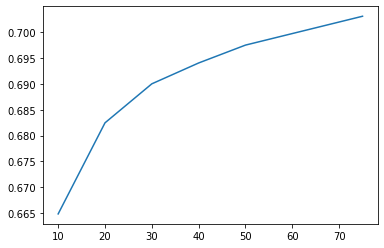

In [13]:
plt.plot(n_trees,np.mean(scores,axis = 1))

* Долго ли настраивались классификаторы? 

Относительно других алгоритмов этого курса - весьма занчительной время. Время настройки прямо пропорционально количеству количеству используемых деревьев: минута для 10 деревьев, 2 для 20, 5 для 50 и т.д.

* Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

Судя по графику, качество работы алгоритма будет расти с увеличением числа деревьев - оптимум не был достигнут.

# Part 2. Logistic Regression

1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?
3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).
4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.
5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?
6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).


Создадим функцию для работы с данными и применим StandardScaler

In [14]:
def get_Xtrain():
    data = pandas.read_csv('./features.csv', index_col='match_id')


    data.drop(['duration', 'radiant_win', 
                'tower_status_radiant',
                'tower_status_dire',
                'barracks_status_radiant',
                'barracks_status_dire'], 
              axis=1, inplace=True)

    data.fillna(0,inplace = True)
    X_train = data
    #X_train = StandardScaler().fit_transform(X_train)
    return X_train

In [15]:
X_train = get_Xtrain()
X_train = StandardScaler().fit_transform(X_train)

## Task №1
 Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?


In [16]:
C_list = [0.01, 0.1, 1, 3, 5 ,10, 15, 20, 50, 100, 500, 1000, 10000]
X_train = StandardScaler().fit_transform(X_train)

In [17]:
def Log_regression(X_train,y_train,cv, C_list):
    scores= []
    for C in C_list:
        start_time = datetime.datetime.now()

        model = LogisticRegression(penalty='l2', C=C)
        scores.append(cross_val_score(estimator=model, X=X_train,y=y_train,cv=cv,scoring="roc_auc"))

        print("\nCoefficient C=",C)
        print("Time've passed", datetime.datetime.now() - start_time)
        print("Kross validation score=", scores[-1])
        print("Mean=", np.mean(scores[-1]))
    print("best result is: ", max(np.mean(scores,axis = 1)))
    return scores

In [18]:
scores_lr = Log_regression(X_train,y_train,cv, C_list)


Coefficient C= 0.01
Time've passed 0:00:04.379026
Kross validation score= [0.71464464 0.71617921 0.71624672 0.71735016 0.7183287 ]
Mean= 0.7165498862352037

Coefficient C= 0.1
Time've passed 0:00:04.590006
Kross validation score= [0.71461975 0.71617653 0.71619111 0.71737604 0.71827129]
Mean= 0.7165269451581027

Coefficient C= 1
Time've passed 0:00:04.576030
Kross validation score= [0.71461609 0.71617193 0.71618261 0.71737575 0.71826417]
Mean= 0.7165221087939807

Coefficient C= 3
Time've passed 0:00:04.366006
Kross validation score= [0.7146161  0.7161738  0.71618208 0.71737564 0.71826384]
Mean= 0.7165222930768822

Coefficient C= 5
Time've passed 0:00:04.630007
Kross validation score= [0.71461638 0.71617381 0.71618194 0.71737578 0.71826395]
Mean= 0.7165223735997814

Coefficient C= 10
Time've passed 0:00:04.590006
Kross validation score= [0.71461633 0.71617159 0.7161817  0.71737581 0.71826403]
Mean= 0.7165218906414321

Coefficient C= 15
Time've passed 0:00:04.550007
Kross validation scor

Логистическая регрессия работает несколько лучше (на 1-2%), чем лучший вариант градинтного бустинга.  
Наилучшее качество логистической регресии составило 71.65% при  C = 0.01.  
У градиентного бустинга лучший результат составил 70% при использовании ансамбля из 75 деревьев.  

Логическая регрессия также работает в несколько раз быстрее - среднее время обучения работы алгоритма около 5 секунд.


Такой разрыв в эффективности говорит о том, что характер зависимости в данных линейный: нет необходимости пробовать более сложные модели.

## Task №2
 Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [19]:
data_copy = data.copy(deep=True)

In [20]:
categorical_features = ['lobby_type','r1_hero','r2_hero','r3_hero','r4_hero','r5_hero',
                        'd1_hero','d2_hero','d3_hero','d4_hero','d5_hero']

data_copy.drop(categorical_features, axis = 1,inplace= True)
X_train = data_copy
X_train = StandardScaler().fit_transform(X_train)
X_train

array([[-2.54436416,  1.40080818,  1.52597175, ..., -0.55115386,
         1.84600409, -1.12149424],
       [-2.54045236,  0.50131354, -0.08013929, ...,  0.67817009,
         0.43778816,  0.04394713],
       [-2.53923104,  0.50131354,  0.1510701 , ...,  0.67817009,
         0.43778816,  0.49028637],
       ...,
       [ 1.09874571,  0.50131354,  0.29226667, ...,  0.67817009,
         0.43778816, -0.20401912],
       [ 1.09895204, -0.39818111, -0.17368203, ...,  0.67817009,
         0.43778816, -0.87352799],
       [ 1.1026479 , -0.39818111, -0.31840851, ..., -0.55115386,
        -0.97042777, -0.79913812]])

In [21]:
scores_no_categorical = Log_regression(X_train,y_train,cv, C_list)


Coefficient C= 0.01
Time've passed 0:00:04.040006
Kross validation score= [0.7145036  0.71621974 0.71627984 0.71725108 0.71854174]
Mean= 0.7165592000076536

Coefficient C= 0.1
Time've passed 0:00:04.220006
Kross validation score= [0.71448111 0.71620877 0.71622672 0.71726946 0.71848302]
Mean= 0.7165338144534041

Coefficient C= 1
Time've passed 0:00:04.170006
Kross validation score= [0.71447746 0.71620674 0.71621937 0.71727383 0.71847432]
Mean= 0.7165303443778955

Coefficient C= 3
Time've passed 0:00:04.190006
Kross validation score= [0.71447654 0.71620792 0.71621947 0.71727403 0.71847456]
Mean= 0.7165305053023285

Coefficient C= 5
Time've passed 0:00:04.270006
Kross validation score= [0.71447722 0.71620784 0.71621936 0.71727419 0.71847435]
Mean= 0.7165305922012413

Coefficient C= 10
Time've passed 0:00:04.210006
Kross validation score= [0.71447697 0.71620771 0.71621935 0.71727417 0.71847447]
Mean= 0.7165305328738455

Coefficient C= 15
Time've passed 0:00:04.290006
Kross validation scor

Качество не изменилось - лучший результат 71.65% в точности равен предыдущему.  
Это говорит о том, что модель эти признаки были распознаны моделью как неважные (шум) в первый раз.

## Task №3
На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).


In [22]:
#categorical_features.remove('lobby_type')
data[categorical_features]

,lobby_type,r1_hero,r2_hero,r3_hero,r4_hero,r5_hero,d1_hero,d2_hero,d3_hero,d4_hero,d5_hero
match_id,,,,,,,,,,,
0,7,11,67,29,20,105,4,42,21,37,84
1,0,42,49,67,37,26,39,88,79,7,12
2,7,33,98,20,27,4,22,66,86,29,80
3,1,29,30,75,37,41,96,48,15,102,20
4,7,13,27,30,72,93,26,69,22,25,8
...,...,...,...,...,...,...,...,...,...,...,...
114402,1,47,7,1,21,71,26,19,93,3,28
114403,0,43,26,4,29,110,72,75,5,20,98
114404,1,98,11,112,81,50,28,39,55,59,31


In [23]:
heroes = np.unique(data[categorical_features].values)
N = len(heroes)
N

109

В игре было доступно 109 уникальных героев.

## Task №4
Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.


In [25]:
X_pick = np.zeros((data.shape[0], 112))

for i, match_id in enumerate(data.index):
    for p in range(5):
        X_pick[i, data.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, data.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [26]:
X_train = np.hstack((data.values, X_pick))
X_train = StandardScaler().fit_transform(X_train)

## Task №5
Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?


In [27]:
scores_world_bag = Log_regression(X_train,y_train,cv, C_list)


Coefficient C= 0.01
Time've passed 0:00:07.583033
Kross validation score= [0.7493279  0.75311781 0.74941106 0.75614986 0.75156977]
Mean= 0.7519152795467527

Coefficient C= 0.1
Time've passed 0:00:08.420012
Kross validation score= [0.7493431  0.75313147 0.74937357 0.75608293 0.75149673]
Mean= 0.7518855587172407

Coefficient C= 1
Time've passed 0:00:08.526038
Kross validation score= [0.74934263 0.75312723 0.74936783 0.75607442 0.75149018]
Mean= 0.7518804597763399

Coefficient C= 3
Time've passed 0:00:08.300012
Kross validation score= [0.74934206 0.75312746 0.74936763 0.75607259 0.75148927]
Mean= 0.751879803016089

Coefficient C= 5
Time've passed 0:00:08.466033
Kross validation score= [0.74934186 0.75312714 0.74936769 0.75607286 0.75148751]
Mean= 0.7518794110729377

Coefficient C= 10
Time've passed 0:00:08.470012
Kross validation score= [0.74934279 0.75312689 0.74936775 0.7560728  0.75148811]
Mean= 0.7518796674710068

Coefficient C= 15
Time've passed 0:00:08.680012
Kross validation score

Качество значительно улучшилось - максимум в 75.19%.  Разница почти в 4%
Значит данные о героях не распозновались корректно до использования мешка слов, теперь же они влияют не предсказание.

## Task №6
 Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [28]:
X_train = get_Xtrain()

X_pick = np.zeros((data.shape[0], 112))

for i, match_id in enumerate(data.index):
    for p in range(5):
        X_pick[i, data.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, data.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
X_train = np.hstack((data.values, X_pick))
X_train = StandardScaler().fit_transform(X_train)

In [29]:
data_test = pandas.read_csv('./features_test.csv', index_col='match_id')
data_test.fillna(0,inplace = True)
data_test.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1430293357,1,20,2,556,570,1,0,0,9,...,2,-29.0,168.0,-54.0,0.0,3,2,2,1,16.0
10,1430301774,1,112,2,751,808,1,0,0,13,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1430323933,1,27,3,708,903,1,1,1,11,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1430331112,1,39,4,1259,661,4,0,0,9,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [31]:
X_test = data_test.values
X_test = np.hstack((data_test.values, X_pick[:X_test.shape[0]]))
X_test = StandardScaler().fit_transform(X_test)

In [32]:
print(X_train.shape, X_test.shape)

(97230, 214) (17177, 214)


In [33]:
model = LogisticRegression(C=0.01).fit(X_train, y_train)
result = model.predict_proba(X_test)

In [34]:
result_pd = pandas.Series(result[:, 1])
result_pd.describe()

count    17177.000000
mean         0.518148
std          0.234618
min          0.004598
25%          0.334798
50%          0.522472
75%          0.708100
max          0.997392
dtype: float64